# Deep Learning: Lesson 1

## References and Datasets

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [Fast.ai Lesson 1](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb)
- [Kaggle ASL Dataset](https://www.kaggle.com/grassknoted/asl-alphabet/home)

## Setup

Lines starting with `%` are special directives ("magics") to tell Jupyter:
- Reload any changes to external libraries / modules automatically
- `matplotlib` should draw plots in-line


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

Load the pre-trained model, ensuring that the `pretrained` flag is set to `True`.

In [32]:
resnet34 = models.resnet34(pretrained=True)

Replace the last fully-connected layer `fc`, which normally has 512 input features and 1000 output features. ![Examples](https://www.nidcd.nih.gov/sites/default/files/Content%20Images/NIDCD-ASL-hands-2014.jpg)

In [33]:
# 512 for ResNet34
number_of_features = resnet34.fc.in_features

# letters A-Z plus SPACE, DELETE, and NOTHING
number_of_classes = 29

# freeze all layers
for i, param in resnet34.named_parameters():
    param.requires_grad = False

# newly created modules have require_grad=True by default
resnet34.fc = nn.Linear(number_of_features, number_of_classes)
print(resnet34.fc)

Linear(in_features=512, out_features=29, bias=True)


## Loading Data

First, download the dataset from Kaggle. Rename the two subdirectories to "train" and "val," respectively. Next, run the following script inside of the "val" directory:

In [34]:
import os
import shutil

for filename in os.listdir('.'):
    # files are named: `A_test.jpg`, etc.
    if filename.endswith('.jpg'):
        # A, B, C, etc.
        folder_name = filename.split('_')[0]

        # make the new folder and move
        os.mkdir(folder_name)
        shutil.move(filename, '{}/{}'.format(folder_name, filename))

Remap and normalize images, based on original ResNet34 training data.

In [35]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Load data: see the [docs](https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder) for additional information on how this class works.

In [36]:
data_dir = '/datasets/asl_alphabet/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

Print some debug information about the training set images.

In [37]:
print(class_names)
print(image_datasets['train'][0][0].size())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
torch.Size([3, 224, 224])


Show a few images from the training set, along with their associated labels.

input tensor size: torch.Size([4, 3, 224, 224])


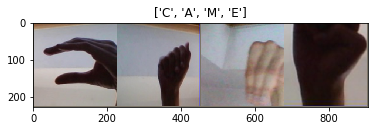

In [38]:
def imshow(tensor, title=None):
    # transpose from (C x H x W) to (H x W x C)
    tensor = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # zero-center and normalize
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    
    # display the image
    plt.imshow(tensor)
    
    if title is not None:
        plt.title(title)
        
    # pause a bit so that plots are updated  
    plt.pause(0.001)  

# inputs will be of size (B x C x H x W)
inputs, classes = next(iter(dataloaders['train']))
print('input tensor size:', inputs.size())

# make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Training

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('using device:', device)

resnet34 = resnet34.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, resnet34.parameters())), lr=0.001, momentum=0.9)
learning_rate_decay = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

using device: cuda:0


View which layers are frozen vs. trainable.

In [51]:
for name_1, child in resnet34.named_children():
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)

weight False
weight False
bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
2.conv1.weight False
2.bn1.weight False
2.bn1.bias False
2.conv2.weight False
2.bn2.weight False
2.bn2.bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
2.conv1.weight False
2.bn1.weight False
2.bn1.bias False
2.conv2.weight False
2.bn2.weight False
2.bn2.bias False
3.conv1.weight False
3.bn1.weight False
3.bn1.bias False
3.conv2.weight False
3.bn2.weight False
3.bn2.bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2

In [52]:
def train_model(model, criterion, optimizer, scheduler, number_of_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(number_of_epochs):
        print('epoch {}/{}'.format(epoch, number_of_epochs - 1))
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass: track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('best val accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [43]:
resnet34 = train_model(resnet34, criterion, optimizer, learning_rate_decay, number_of_epochs=4)

epoch 0/3
----------
train Loss: 1.8894 Acc: 0.4706
val Loss: 1.3974 Acc: 0.8571

epoch 1/3
----------
train Loss: 1.6654 Acc: 0.5386
val Loss: 1.5159 Acc: 0.8571

epoch 2/3
----------
train Loss: 1.6325 Acc: 0.5534
val Loss: 1.3866 Acc: 0.9286

epoch 3/3
----------
train Loss: 1.6244 Acc: 0.5529
val Loss: 1.4062 Acc: 0.8929

training complete in 15m 13s
best val Acc: 0.928571


## Evaluation

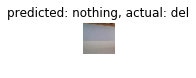

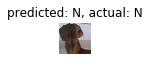

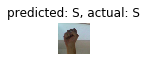

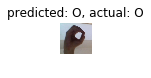

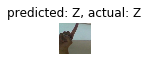

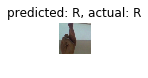

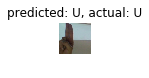

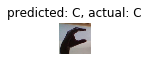

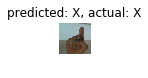

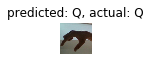

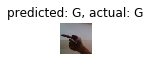

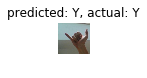

In [49]:
def visualize_model(model, number_of_images=12):
    was_training = model.training
    model.eval()
    
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # upload tensor data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                # recall that class names are converted to numeric indices
                class_pred = class_names[preds[j]]
                class_real = class_names[labels[j]]
                
                ax = plt.subplot(number_of_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, actual: {}'.format(class_pred, class_real))
                imshow(inputs.cpu().data[j])

                if images_so_far == number_of_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

visualize_model(resnet34)